# Imports & Function

**Note: we should only perform this acquisition method on ~20ms sections of data, see book for details**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math
from GoldCode import GoldCode

# Start of ByteToIQPairs Function
def ByteToIQPairs( TheByte ):
    IQPairs = []
    
    # A bit long and drawn out, but this code reads
    # each pair of bits from the byte and determines
    # sign and magnitude, then returns list containing
    # two pairs of IQ data as floating point [I1,Q1,I2,Q2]
    # For magnitude: 1 means mag 1, 0 means mag 1/3
    # For sign: 1 means negative, 0 means positive
    # This interpretation was taken by the sample code provided
    # in the PSAS Launch12 github repo (example was provided in C)
    IMag1 = (TheByte >> 7) & (0b00000001)
    ISign1 = (TheByte >> 6) & (0b00000001)
    if (IMag1 == 1):
        I1 = 1.0
    else:
        I1 = 1.0/3.0
    if (ISign1 == 1): 
        I1 = -I1
    IQPairs.append(I1)
    
    QMag1 = (TheByte >> 5) & (0b00000001)
    QSign1 = (TheByte >> 4) & (0b00000001)
    if (QMag1 == 1):
        Q1 = 1.0
    else:
        Q1 = 1.0/3.0
    if (QSign1 == 1): 
        Q1 = -Q1
    IQPairs.append(Q1)    
        
    IMag2 = (TheByte >> 3) & (0b00000001)
    ISign2 = (TheByte >> 2) & (0b00000001)
    if (IMag2 == 1):
        I2 = 1.0
    else:
        I2 = 1.0/3.0
    if (ISign2 == 1): 
        I2 = -I2
    IQPairs.append(I2)    
        
    QMag2 = (TheByte >> 1) & (0b00000001)
    QSign2 = (TheByte >> 0) & (0b00000001)
    if (QMag2 == 1):
        Q2 = 1.0
    else:
        Q2 = 1.0/3.0
    if (QSign2 == 1): 
        Q2 = -Q2
    IQPairs.append(Q2)
    
    return IQPairs 
# End of ByteToIQPairs Function


# Import data File

In [3]:
# Beginning of main code
# Open data file
# Information on file "JGPS@-32.041913222" can be found at: 
# https://github.com/psas/Launch-12/tree/gh-pages/data/GPS
print("Opening a file.")
f = open('JGPS@-32.041913222','r', encoding = 'utf-8', errors = 'ignore')
print("File handle is: %d." % (f.fileno()))

# Read file one byte at a time, extract the two 
# IQ pairs, and store in array, after conversion to float.
# Will keep track of number of bytes read, in order to do a 
# partial read. Otherwise, will read file until the end.
StartingBit = 1
TotalBits = 100
i = StartingBit
SingleByte = f.read(1)
IData = []
QData = []
while SingleByte != "":
    IQPairs = ByteToIQPairs(ord(SingleByte))
    IData.append(IQPairs[0])
    IData.append(IQPairs[2])
    QData.append(IQPairs[1])
    QData.append(IQPairs[3])
    #print("I: %f, Q: %f ." % (IQPairs[0], IQPairs[1]))
    #print("I: %f, Q: %f ." % (IQPairs[2], IQPairs[3]))
    
    i += 1
    if i > (TotalBits - StartingBit):
        break
    SingleByte = f.read(1)

f.close()
print("File is now closed.")

Opening a file.
File handle is: 52.
File is now closed.


# Convert to complex array

In [4]:
print("length of IData is: %d" % (len(IData)))
print("Length of QData is: %d" % (len(QData)))

CData = np.zeros(len(IData), dtype=np.complex)

for d in range(len(IData)):
	CData[d] = IData[d] + QData[d] * 1j
    
#print(CData)

length of IData is: 198
Length of QData is: 198


# LO Sweep

- Between these 2 steps we need to sweep the local oscillator due to Doppler effect
- Pick a frequency, and run the steps from here assuming the Doppler shift puts us @ that freq
- We need to multiply the incoming data by a complex sine wave 
- The frequency of the generated wave is equal to the difference between the actual and target frequencies
- The sine wave must be complex in order to get a negative frequency (sweep both directions)
- Book recommends +/- 10kHz in 500Hz steps (pg 77)
- 

# Take fft

In [5]:
ffI = np.fft.fft(IData, 2048)
ffQ = np.fft.fft(QData, 2048)

# Reference data size section of book to pick the len param. Should be based sample rate
ffC = np.fft.fft(CData, 2048)

# Plot output

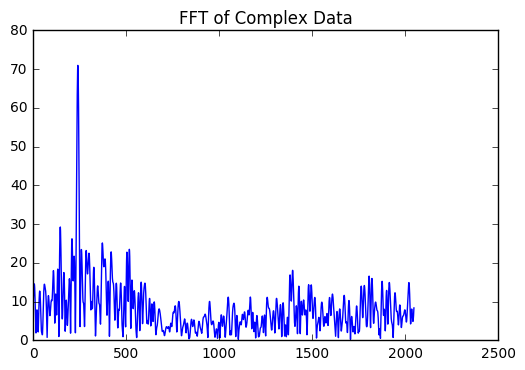

In [14]:
#plt.plot(IData)
#plt.plot(QData)

#plt.plot(ffI)
#plt.plot(ffQ)
plt.plot(np.abs(ffC))

plt.title("FFT of Complex Data")

plt.show()

# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.

- Options: for loop, write new method, numpy function?

In [16]:
sat = (7, 9)

CodeGen = GoldCode(sat)
code = CodeGen.getCode(1023)

#print(code)

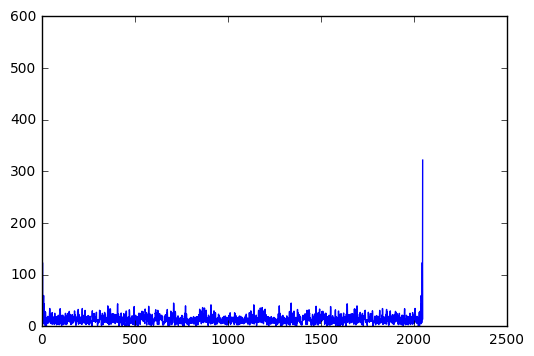

In [20]:
Codefft = np.fft.fft(code, 2048)

plt.plot(np.abs(Codefft))

plt.show()

# Complex Conjugate of Gold Code fft

real(fft) - imag(fft)j

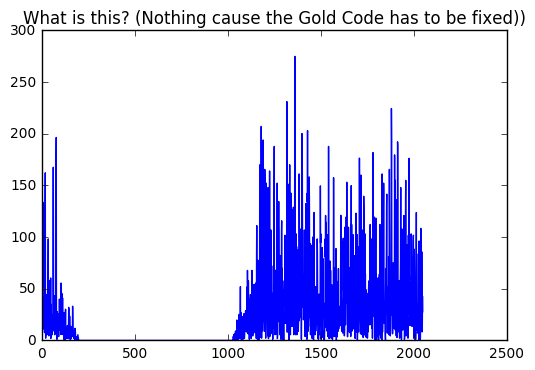

In [19]:
GCConj = np.conjugate(Codefft)

result = np.fft.ifft(GCConj * ffC)

resultSQ = np.abs(result) ** 2

plt.plot(resultSQ)
plt.title("What is this? (Nothing cause the Gold Code has to be fixed))")
plt.show()

# Notes

- From book appendix: we should look for the top 2 peaks, and use the ratio to determine whether there is a signal or just noise
- We should get the C code running and be sure to compare results. Acquisition works in the C code, but tracking is untested